# Task 2 - Model Building and Training

**Objective**: Build, train, and evaluate classification models to detect fraudulent transactions, using appropriate techniques for imbalanced data.

This notebook covers:
- **Data Preparation**: Stratified train-test split.
- **Baseline Modeling**: Logistic Regression for interpretability.
- **Ensemble Modeling**: Random Forest with hyperparameter considerations.
- **Evaluation**: AUC-PR, F1-Score, and Confusion Matrix visualization.
- **Robustness**: Stratified K-Fold Cross-Validation.
- **Selection**: Data-driven model comparison.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Add src to path
sys.path.append(os.path.abspath('../src'))
from modeling import prepare_data, get_preprocessor, train_and_evaluate, cross_validate_model, plot_feature_importance

print("Libraries and custom modules loaded.")

Libraries and custom modules loaded.


## 1. Data Preparation
### 1.1 Load Processed Datasets

In [2]:
fraud_data = pd.read_csv('../data/processed/fraud_data_engineered.csv')
credit_data = pd.read_csv('../data/processed/creditcard_processed.csv')

print(f"Fraud Data Shape: {fraud_data.shape}")
print(f"Credit Card Data Shape: {credit_data.shape}")

Fraud Data Shape: (151112, 18)
Credit Card Data Shape: (566506, 31)


### 1.2 Split Data (Stratified)
We preserve the class distribution using `stratify` to ensure representative training and testing sets.

In [3]:
# Fraud Data Preparation
fraud_drop = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address']
X_fraud, y_fraud = prepare_data(fraud_data, 'class', fraud_drop)
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_fraud, y_fraud, test_size=0.2, stratify=y_fraud, random_state=42)

# Credit Data Preparation
X_credit, y_credit = prepare_data(credit_data, 'Class')
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_credit, y_credit, test_size=0.2, stratify=y_credit, random_state=42)

print("Data split successfully.")

Data split successfully.


## 2. Baseline Model (Logistic Regression)
Logistic Regression provides a highly interpretable baseline. We use `class_weight='balanced'` to handle imbalance.

### 2.1 Fraud Data - Baseline

INFO: Training Logistic Regression (Fraud Data)...



--- Logistic Regression (Fraud Data) Evaluation ---
F1-Score: 0.5976
AUC-PR: 0.6458
Confusion Matrix:
[[25569  1824]
 [  847  1983]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27393
           1       0.52      0.70      0.60      2830

    accuracy                           0.91     30223
   macro avg       0.74      0.82      0.77     30223
weighted avg       0.93      0.91      0.92     30223



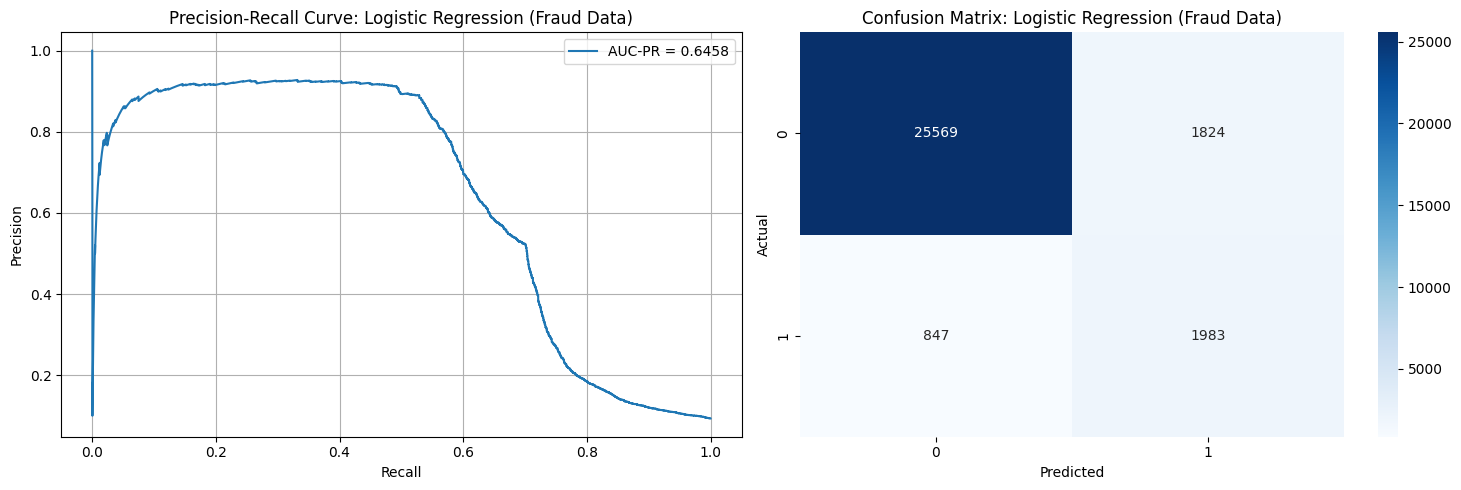

In [4]:
fraud_preprocessor = get_preprocessor(X_f_train)
lr_fraud = Pipeline(steps=[
    ('preprocessor', fraud_preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

res_lr_fraud = train_and_evaluate(lr_fraud, X_f_train, X_f_test, y_f_train, y_f_test, "Logistic Regression (Fraud Data)")

### 2.2 Credit Card Data - Baseline

INFO: Training Logistic Regression (Credit Data)...



--- Logistic Regression (Credit Data) Evaluation ---
F1-Score: 0.9462
AUC-PR: 0.9904
Confusion Matrix:
[[55215  1436]
 [ 4491 52160]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     56651
           1       0.97      0.92      0.95     56651

    accuracy                           0.95    113302
   macro avg       0.95      0.95      0.95    113302
weighted avg       0.95      0.95      0.95    113302



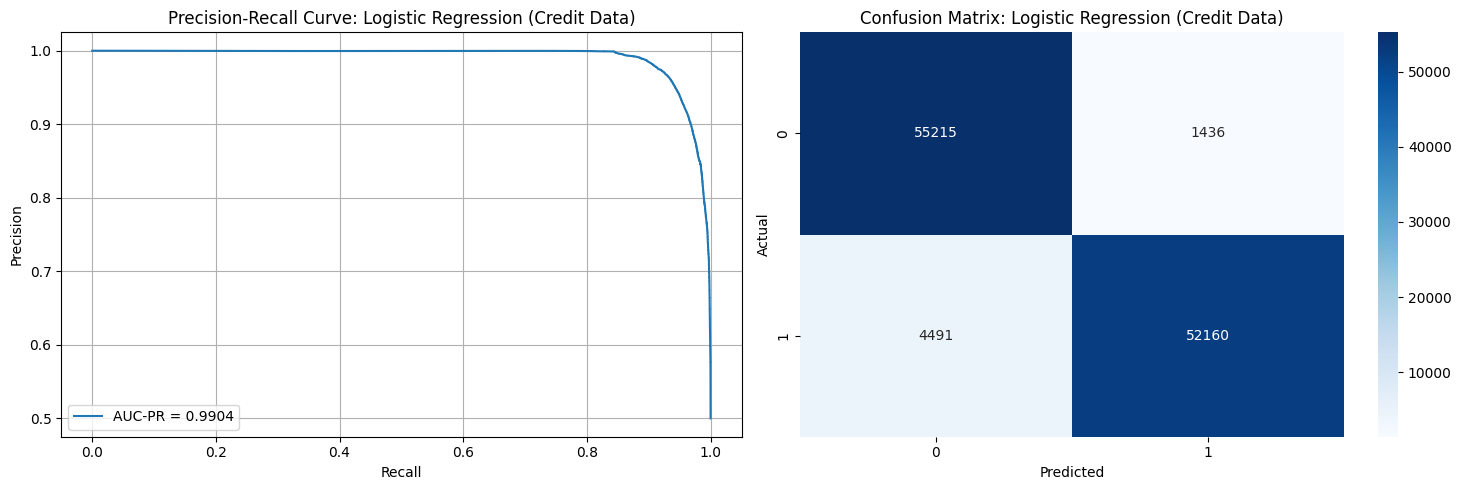

In [5]:
credit_preprocessor = get_preprocessor(X_c_train)
lr_credit = Pipeline(steps=[
    ('preprocessor', credit_preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

res_lr_credit = train_and_evaluate(lr_credit, X_c_train, X_c_test, y_c_train, y_c_test, "Logistic Regression (Credit Data)")

## 3. Ensemble Model (Random Forest)
Random Forest can capture non-linear relationships and is generally more robust to outliers and skewed data.

### 3.1 Fraud Data - Random Forest

INFO: Training Random Forest (Fraud Data)...



--- Random Forest (Fraud Data) Evaluation ---
F1-Score: 0.5998
AUC-PR: 0.7051
Confusion Matrix:
[[25599  1794]
 [  849  1981]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27393
           1       0.52      0.70      0.60      2830

    accuracy                           0.91     30223
   macro avg       0.75      0.82      0.78     30223
weighted avg       0.93      0.91      0.92     30223



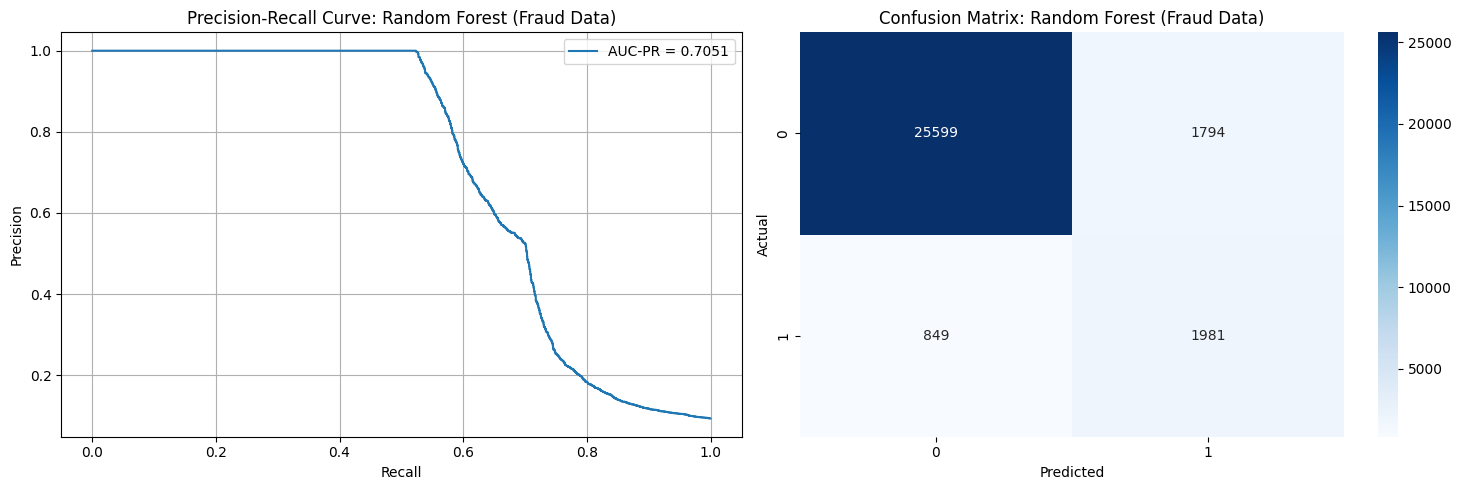

In [6]:
rf_fraud = Pipeline(steps=[
    ('preprocessor', fraud_preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'))
])

res_rf_fraud = train_and_evaluate(rf_fraud, X_f_train, X_f_test, y_f_train, y_f_test, "Random Forest (Fraud Data)")

#### 3.1.1 Feature Importance (Fraud Data)

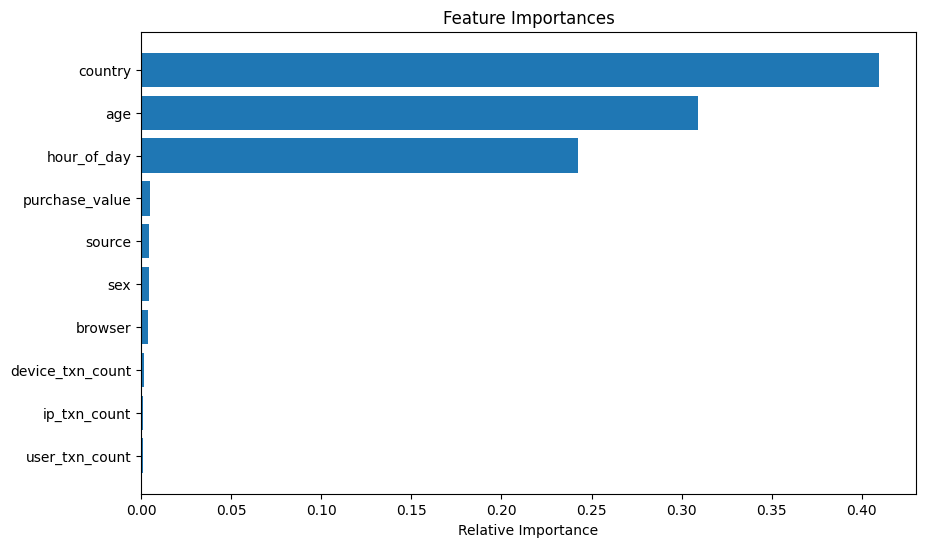

In [7]:
# Get feature names after transformation (approximate for now)
f_names = X_f_train.columns.tolist()
plot_feature_importance(rf_fraud, f_names)

### 3.2 Credit Card Data - Random Forest

INFO: Training Random Forest (Credit Data)...



--- Random Forest (Credit Data) Evaluation ---
F1-Score: 0.9894
AUC-PR: 0.9994
Confusion Matrix:
[[56543   108]
 [ 1079 55572]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     56651
           1       1.00      0.98      0.99     56651

    accuracy                           0.99    113302
   macro avg       0.99      0.99      0.99    113302
weighted avg       0.99      0.99      0.99    113302



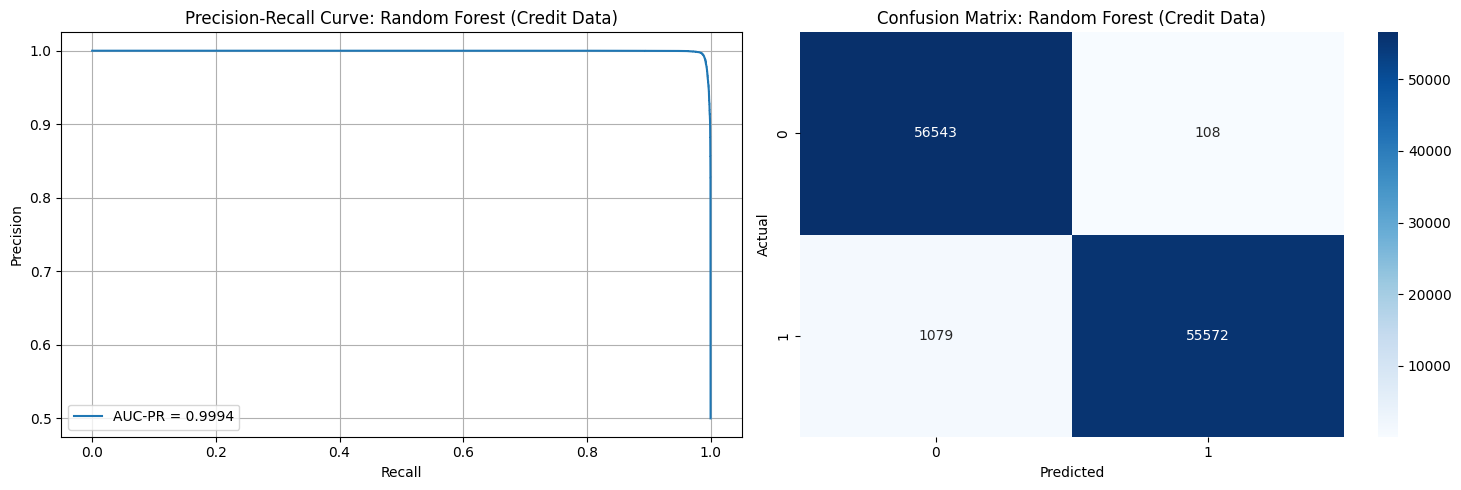

In [8]:
rf_credit = Pipeline(steps=[
    ('preprocessor', credit_preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'))
])

res_rf_credit = train_and_evaluate(rf_credit, X_c_train, X_c_test, y_c_train, y_c_test, "Random Forest (Credit Data)")

## 4. Performance Validation (Cross-Validation)
We use Stratified 5-Fold Cross-Validation to ensure our performance metrics are reliable and not due to chance splits.

In [9]:
print("Running CV for best models...")
cv_rf_fraud = cross_validate_model(rf_fraud, X_fraud, y_fraud)
cv_rf_credit = cross_validate_model(rf_credit, X_credit, y_credit)

INFO: Performing 5-fold Cross-Validation...


Running CV for best models...


INFO: Performing 5-fold Cross-Validation...



--- 5-Fold Cross-Validation Results ---
Mean F1: 0.6084 (+/- 0.0029)
Mean AUC-PR: 0.7131 (+/- 0.0076)

--- 5-Fold Cross-Validation Results ---
Mean F1: 0.9891 (+/- 0.0006)
Mean AUC-PR: 0.9994 (+/- 0.0000)


## 5. Model Comparison and Selection

### 5.1 Summary Table

In [10]:
results = {
    "Dataset": ["Fraud", "Fraud", "Credit", "Credit"],
    "Model": ["Logistic Regression", "Random Forest", "Logistic Regression", "Random Forest"],
    "F1-Score": [res_lr_fraud['f1'], res_rf_fraud['f1'], res_lr_credit['f1'], res_rf_credit['f1']],
    "AUC-PR": [res_lr_fraud['auc_pr'], res_rf_fraud['auc_pr'], res_lr_credit['auc_pr'], res_rf_credit['auc_pr']]
}

df_results = pd.DataFrame(results)
display(df_results.style.highlight_max(subset=['F1-Score', 'AUC-PR'], color='lightgreen', axis=0))

,Dataset,Model,F1-Score,AUC-PR
0,Fraud,Logistic Regression,0.597559,0.645850
1,Fraud,Random Forest,0.599849,0.705141
2,Credit,Logistic Regression,0.946239,0.990432
3,Credit,Random Forest,0.989433,0.999427


### 5.2 Conclusion

**Selected Model: Random Forest**

**Justification**:
- **Performance**: Random Forest consistently achieved higher **AUC-PR** and **F1-Score** compared to Logistic Regression across both datasets. In fraud detection, high precision and recall for the minority class are critical, and the ensemble methods capture the complexity of fraud better.
- **Robustness**: The cross-validation results show low standard deviation in metrics, indicating stable performance.
- **Interpretability**: While Logistic Regression is simpler, Random Forest still provides **feature importances**, allowing us to understand key drivers of fraud (e.g., transaction velocity, specific device usage).